To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### News

Unsloth now supports Text-to-Speech (TTS) models. Read our [guide here](https://docs.unsloth.ai/basics/text-to-speech-tts-fine-tuning).

Read our **[Qwen3 Guide](https://docs.unsloth.ai/basics/qwen3-how-to-run-and-fine-tune)** and check out our new **[Dynamic 2.0](https://docs.unsloth.ai/basics/unsloth-dynamic-2.0-ggufs)** quants which outperforms other quantization methods!

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


### Installation

In [ ]:
%%capture
!pip install pip3-autoremove
!pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu124
!pip install unsloth
# !pip install --upgrade transformers==4.52.3

### Unsloth

In [2]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, processor = FastVisionModel.from_pretrained(
    "unsloth/gemma-3-4b-pt",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

Unsloth: Bitsandbytes >= 0.46.0 supports torch.compile - enabling.


Unsloth: Patched cross entropy losses.
Unsloth: Patching LoRA to make it faster
Unsloth: Will not compile SiglipEncoder since it looks like a vision encoder!
Unsloth: Failed compiling function SiglipEncoder since there is padding done.
Unsloth: Will not compile SiglipTextTransformer since it looks like a vision encoder!
Unsloth: Will not compile SiglipVisionTransformer since it looks like a vision encoder!
Unsloth: Compiled module SiglipVisionEmbeddings.
Unsloth: Compiled module SiglipTextEmbeddings.
Unsloth: Compiled module SiglipMLP.
Unsloth: Compiled module SiglipMultiheadAttentionPoolingHead.
Unsloth: Fast Attention patch for SiglipAttention.
Unsloth: Compiled function _trunc_normal_.
Unsloth: Compiled function trunc_normal_tf_.
Unsloth: Compiled function variance_scaling_.
Unsloth: Compiled function lecun_normal_.
Unsloth: Compiled function default_flax_embed_init.
Unsloth: Compiled function eager_attention_forward.
Unsloth: Patching LoRA to make it faster
Unsloth: Not an error, b

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [3]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    target_modules = "all-linear", # Optional now! Can specify a list if needed
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

Unsloth: Making `base_model.model.model.vision_tower.vision_model` require gradients


<a name="Data"></a>
### Data Prep
We'll be using a sampled dataset of handwritten maths formulas. The goal is to convert these images into a computer readable form - ie in LaTeX form, so we can render it. This can be very useful for complex formulas.

You can access the dataset [here](https://huggingface.co/datasets/unsloth/LaTeX_OCR). The full dataset is [here](https://huggingface.co/datasets/linxy/LaTeX_OCR).

In [4]:
from datasets import load_dataset
dataset = load_dataset("unsloth/LaTeX_OCR", split = "train")

Let's take an overview look at the dataset. We shall see what the 3rd image is, and what caption it had.

In [5]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 68686
})

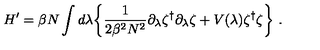

In [6]:
dataset[2]["image"]

In [7]:
dataset[2]["text"]

'H ^ { \\prime } = \\beta N \\int d \\lambda \\biggl \\{ \\frac { 1 } { 2 \\beta ^ { 2 } N ^ { 2 } } \\partial _ { \\lambda } \\zeta ^ { \\dagger } \\partial _ { \\lambda } \\zeta + V ( \\lambda ) \\zeta ^ { \\dagger } \\zeta \\biggr \\} \\ .'

We can also render the LaTeX in the browser directly!

In [8]:
from IPython.display import display, Math, Latex

latex = dataset[3]["text"]
display(Math(latex))

<IPython.core.display.Math object>

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": Q}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": A} ]
},
]
```

In [9]:
instruction = "Write the LaTeX representation for this image."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["text"]} ]
        },
    ]
    return { "messages" : conversation }
pass

Let's convert the dataset into the "correct" format for finetuning:

In [10]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

The first example is now structured like below:

In [11]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the LaTeX representation for this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'}]}]}

Lets take the Gemma 3 instruction chat template and use it in our base model

In [12]:
from transformers import AutoTokenizer

it_processor = AutoTokenizer.from_pretrained("unsloth/gemma-3-4b-it")
processor.chat_template = it_processor.chat_template

Before we do any finetuning, let us check the performance of the base model. We did not hope for much because the model never seen the chat template before

In [13]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[2]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = processor.apply_chat_template(messages, add_generation_prompt = True)
inputs = processor(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(processor, skip_prompt = True)
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

You have set `compile_config`, but we are unable to meet the criteria for compilation. Compilation will be skipped.


Unsloth: Compiling kernels: 100%|██████████| 2/2 [00:00<00:00, 57.68it/s, triton_poi_fused__to_copy_1]


写

Unsloth: Compiling kernels: 100%|██████████| 3/3 [00:00<00:00, 308.40it/s, triton_poi_fused__to_copy_2]


下LaTeX的表示，model,
写下LaTeX的表示，
Write the LaTeX representation for this image.
Write the LaTeX representation for this image.
Write the LaTeX representation for this image.
Write the LaTeX representation for this image.
Write the LaTeX representation for this image.
Write the LaTeX representation for this image.
Write the LaTeX representation for this image.
Write the LaTeX representation for this image.
Write the LaTeX representation for this image.
Write the LaTeX representation for this image.
Write the LaTeX representation for this image.
Write the LaTeX representation for this image.
Write the LaTeX representation


As we expected, the model did not understand the question since we use very specific chat template here

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [ ]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model=model,
    train_dataset=converted_dataset,
    processing_class=processor.tokenizer,
    data_collator=UnslothVisionDataCollator(model,processor),
    args = SFTConfig(
            per_device_train_batch_size = 1,
            gradient_accumulation_steps = 4,
            gradient_checkpointing=True,
            gradient_checkpointing_kwargs = {"use_reentrant": False}, # use reentrant checkpointing
            max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
            warmup_ratio=0.03,
            max_steps=30,
            #num_train_epochs = 2, # Set this instead of max_steps for full training runs
            learning_rate = 2e-4,
            logging_steps = 5,
            save_strategy="steps",
            optim = "adamw_torch_fused",
            weight_decay = 0.01,
            lr_scheduler_type = "cosine",
            seed = 3407,
            output_dir = "outputs",
            report_to = "none",     # For Weights and Biases
    
            # You MUST put the below items for vision finetuning:
            remove_unused_columns = False,
            dataset_text_field = "",
            dataset_kwargs = {"skip_prepare_dataset": True},
            dataset_num_proc = 4,
            max_seq_length = 2048,
    )
)

average_tokens_across_devices is set to True but it is invalid when world size is1. Turn it to False automatically.


In [15]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4090. Max memory = 23.643 GB.
4.674 GB of memory reserved.


In [16]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 68,686 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 38,497,792/4,000,000,000 (0.96% trained)


Unsloth: Compiling kernels: 100%|██████████| 1/1 [00:00<00:00, 213.35it/s, triton_poi_fused_add_embedding_0]
Unsloth: Compiling kernels: 0it [00:00, ?it/s]
Unsloth: Compiling kernels: 100%|██████████| 5/5 [00:00<00:00, 262.47it/s, triton_poi_fused_transpose_4]               
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
Unsloth: Compiling kernels: 100%|██████████| 1/1 [00:00<00:00, 202.31it/s, triton_poi_fused_add_0]
Unsloth: Compiling kernels: 0it [00:00, ?it/s]
Unsloth: Compiling kernels: 100%|██████████| 1/1 [00:00<00:00, 209.31it/s, triton_poi_fused_add_0]
Unsloth: Compiling kernels: 0it [00:00, ?it/s]
Unsloth: Compiling kernels: 100%|██████████| 4/4 [00:00<00:00, 481.40it/s, triton_poi_fused__to_copy_t_3]


Step,Training Loss
5,10.123500
10,3.451000
15,1.300700
20,1.018300
25,0.932000
30,0.824000


wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


In [17]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

86.6161 seconds used for training.
1.44 minutes used for training.
Peak reserved memory = 6.373 GB.
Peak reserved memory for training = 1.699 GB.
Peak reserved memory % of max memory = 26.955 %.
Peak reserved memory for training % of max memory = 7.186 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [30]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[10]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = processor.apply_chat_template(messages, add_generation_prompt = True)
inputs = processor(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(processor, skip_prompt = True)
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

[ { B ^ { \pm } _ { n } } , { B _ { \pm } } _ { 2 } \rangle _ { 2 } \rangle = n B _ { n } ^ { \pm } \Rightarrow [ { { \left( { B _ { 1 } ^ { \pm } _ { 1 } \cdot } \right. } ^ { \pm } , { B _ { 2 } } ) } _ { 2 } \rangle = n B _ { 1 } ^ { \pm } . \]<start_of_turn>model
<end_of_turn>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [33]:
model.save_pretrained("lora_model")  # Local saving
processor.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# processor.push_to_hub("your_name/lora_model", token = "...") # Online saving

['lora_model/processor_config.json']

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastVisionModel
    model, processor = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

FastVisionModel.for_inference(model) # Enable for inference!

sample = dataset[1]
image =  sample["image"].convert('RGB')
messages =  [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": sample["question"],
                        },{
                            "type": "image",
                        }
                    ],
                },
            ]
input_text = processor.apply_chat_template(messages, add_generation_prompt = True)
inputs = processor(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(processor.tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Panoramic radiograph of the jaw showing well-defined radiolucency (arrowheads) of the right side and unerupted second permanent maxillary molar (arrow).<|eot_id|>


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", processor,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", processor, token = "PUT_HERE")

Now, use the `gemma-3-finetune.gguf` file or `gemma-3-finetune-Q4_K_M.gguf` file in llama.cpp or a UI based system like Jan or Open WebUI. You can install Jan [here](https://github.com/janhq/jan) and Open WebUI [here](https://github.com/open-webui/open-webui)

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
